# Part 1 — Training the Continuous VAE on CIFAR-10 for Structured Latents (4x4xD)

In the first stage of the project, the focus was on training a **continuous Variational Autoencoder (VAE)** on the CIFAR-10 dataset. The main goal was to achieve high-quality image reconstructions while building a well-structured latent space. Each image is represented as a latent map of size $4 \times 4 \times D$, which later serves as the foundation for geodesic quantization.

## Goals and Setup
The project started by organizing the repository into separate folders for data, models, results, and utilities. This ensured reproducibility and made debugging more straightforward. The CIFAR-10 dataset was chosen as a balanced compromise between visual complexity and computational feasibility, containing 60,000 images of size $32 \times 32$ across 10 classes. To make experiments repeatable, a fixed random seed (`SEED=42`) was set.

## VAE Architecture
The VAE was built using a **CNN-based encoder and decoder**. The encoder compresses an input image from $32 \times 32$ down to a $4 \times 4$ latent representation, while the decoder reconstructs the original $32 \times 32 \times 3$ image.  
The latent space is structured as $4 \times 4 \times 64$, which means that each image is represented by 16 latent vectors (or “tokens”). To stabilize training, the architecture makes use of ResBlocks, GroupNorm, and the smooth SiLU activation function. Additionally, the log-variance is clamped between $-10$ and $10$ to avoid numerical instabilities.

## Loss and Regularization
The training objective combines **mean absolute error (MAE)** for reconstruction with a KL divergence term. To prevent the model from ignoring the latent variables (*posterior collapse*), a **capacity scheduling strategy** was used: the KL divergence capacity gradually increases from 0 to 1600 nats over 60 epochs. This ensures that the latent space remains informative without becoming redundant.  
The coefficient $\beta$ was kept constant at 0.8 throughout training, and the *free bits* technique was disabled, as capacity scheduling alone proved sufficient.

## Training Process and Diagnostics
The model was trained for 180 epochs with the Adam optimizer, using a learning rate of `2e-4` and a batch size of 256. The best checkpoint (`vae_cifar10.pth`) was selected based on a loss metric that balances reconstruction error and KL regularization. Early stopping was applied, with a patience of 70 epochs.  
After training, a latent space analysis confirmed that all 64 dimensions were active and informative, with no signs of posterior collapse. On average, the KL divergence reached about 1600 nats per sample. Visual inspection of reconstructed images showed clean and faithful reconstructions, without noticeable artifacts.

## Outputs for the Next Stages
At the end of Part 1, several essential artifacts were produced:
- The trained model (`vae_cifar10.pth`).  
- Latent means $\mu(x)$ for all training images, stored in arrays of shape `(N_images, 4, 4, 64)` (`training_latent_mus_*.npy`).  
- Standardization statistics (`mu_train`, `sigma_train`), saved in `geoq_standardization_stats.npz` for later use.  

These outputs lay the groundwork for **Part 2**, where a k-NN graph will be constructed, and geodesic K-Medoids clustering will be applied to quantize the latent space.

---


### [Cell 1] Recap
- **Imports & Setup:** Loaded core Python, PyTorch, torchvision, and utility libraries.  
- **Paths:** Created directories for data, models, results, and utils.  
- **Seed & Device:** Fixed `SEED=42` for reproducibility; set device to GPU if available.  
- **Hyperparameters:** `LATENT_DIM=64`, `EPOCHS=180`, `BATCH_SIZE=256`, `LR=2e-4`.  
- **VAE Regime:** β-constant (`0.8`), KL capacity scheduling up to 1600 nats over 60 epochs, free bits disabled.  
- **Data:** CIFAR-10 loaded with `ToTensor()`, wrapped in `DataLoader` (train/test, workers=4, pin memory if GPU).  
- **Checkpoint:** Main model save path → `results/vae_cifar10.pth`.  


In [ ]:
#[Cell 1] Common imports + global setup
import os, math, time, json, csv, random
from pathlib import Path
from datetime import datetime

import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

#Root & paths
ROOT         = Path.cwd()
DATA_PATH    = ROOT / "data"
MODELS_PATH  = ROOT / "models"
RESULTS_PATH = ROOT / "results"
UTILS_PATH   = ROOT / "utils"

for p in [DATA_PATH, MODELS_PATH, RESULTS_PATH, UTILS_PATH]:
    p.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("DATA_PATH:", DATA_PATH)
print("MODELS_PATH:", MODELS_PATH)
print("RESULTS_PATH:", RESULTS_PATH)
print("UTILS_PATH:", UTILS_PATH)

#Seed & device
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

#Main hyperparameters
LATENT_DIM    = 64
NUM_EPOCHS    = 180
BATCH_SIZE    = 256
LEARNING_RATE = 2e-4

#β-constant regime + capacity scheduling
BETA_CONST      = 0.8
CAPACITY_MAX    = 1600
CAPACITY_WARMUP = 60
FREE_BITS       = 0.0

def capacity_schedule(epoch, C_max=CAPACITY_MAX, warmup=CAPACITY_WARMUP):
    t = min(max(epoch / warmup, 0.0), 1.0)
    return float(C_max * t)

#Dataset & DataLoader
transform = transforms.ToTensor()  # CIFAR-10 in [0,1]

train_dataset = datasets.CIFAR10(root=DATA_PATH.as_posix(), train=True,  download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root=DATA_PATH.as_posix(), train=False, download=True, transform=transform)

NUM_WORKERS = 4
PIN_MEM = torch.cuda.is_available()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEM)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEM)

print(f"Train set images: {len(train_dataset)} | Test set images: {len(test_dataset)}")



#Main checkpoint path
MODEL_SAVE_PATH = RESULTS_PATH / "vae_cifar10.pth"


ROOT: c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project
DATA_PATH: c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\data
MODELS_PATH: c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\models
RESULTS_PATH: c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results
UTILS_PATH: c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\utils


### [Cell 2] VAE

The file `vae.py` defines the architecture of a **convolutional Variational Autoencoder (VAE)**, designed to process images and learn a structured latent representation. Each image is encoded into a **$4 \times 4$ latent map**, which will later be used for geodesic quantization and autoregressive modeling.

#### Utility Blocks

- **`ConvGNAct` (Conv + GroupNorm + SiLU)**  
  A small building block combining a 2D convolution, group normalization, and the SiLU activation.  
  *Why:* GroupNorm is stable even with small batches, and SiLU provides smooth, effective non-linearity.  

- **`ResBlock` (Residual Block)**  
  Helps train deeper networks by using skip connections. Two `ConvGNAct` layers are stacked, and if the input/output channels differ, a $1\times1$ convolution aligns them.  

#### Main Components

- **`Encoder`**  
  Compresses the input image (e.g., $32 \times 32 \times 3$ for CIFAR-10) into a latent representation.  
  The spatial size is progressively reduced ($32 \to 16 \to 8 \to 4$), while channels increase.  
  It outputs two tensors:  
  - $\mu$ (mean)  
  - $\log\sigma^2$ (log-variance), clamped in $[-10, 10]$ for numerical stability.  
  Both have shape `(batch, D, 4, 4)`, with $D=64$.  

- **`Decoder`**  
  Expands the latent map back into an image. Starting from $4 \times 4$, it applies transposed convolutions to upsample step by step until reaching $32 \times 32$.  
  The final output passes through a **sigmoid** to ensure pixel values lie in $[0,1]`.  

- **`VAE`**  
  The core class combining encoder and decoder.  
  Steps:  
  1. Input image → encoder → $\mu$, $\log\sigma^2$.  
  2. Sample latent $z$ using the **reparameterization trick**:  
     $$
     z = \mu + \exp\!\big(0.5 \cdot \log\sigma^2\big) \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0,I)
     $$  
  3. Decode $z$ back into a reconstructed image.  

#### Why a $4 \times 4$ Latent Map?
Instead of a single vector, the model uses **16 latent tokens per image** arranged in a $4 \times 4$ grid. This preserves spatial structure, making it easier for later stages (quantization and autoregressive modeling) to capture both local and global dependencies between different image regions.


In [ ]:
#[Cell 2] Importing VAE from vae.py
model = VAE(latent_dim=LATENT_DIM).to(device)
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Parametri addestrabili: 3,289,603


- The encoder outputs a latent tensor with shape `(D, H, W)`, where:  
  - `D` = depth (number of channels, here 64),  
  - `H` and `W` = height and width (here 4 × 4).  

- By multiplying these together, the code computes the **total number of latent units per image**:  
  $$
  4 \times 4 \times 64 = 1024
  $$
This confirms that each input image is represented by **1024 latent values**, structured as a $4 \times 4$ grid of 64-dimensional vectors.


In [ ]:
# --- taglia latente (D,H,W) una volta sola ---
with torch.no_grad():
    # prendi 1 immagine reale dal loader per avere la size giusta e il device giusto
    example = next(iter(train_loader))[0][:1].to(device)   # shape (1,3,32,32) CIFAR
    mu0, _ = model.encoder(example)                        # (1, D, H, W)
D_lat, H_lat, W_lat = mu0.shape[1:]
N_LAT_UNITS = int(D_lat * H_lat * W_lat)
print(f"[latent] D={D_lat}  H={H_lat}  W={W_lat}  => N={N_LAT_UNITS} units per image")


[latente] D=64  H=4  W=4  => N=1024 unità per immagine


### [Cell 3] VAE LOSS

The function `vae_loss_capacity` defines how the **total loss** of the Variational Autoencoder is computed.  
Its purpose is to balance two things:
1. How well the image is reconstructed.  
2. How much information is kept in the latent space.  

It follows the idea of **capacity scheduling per channel** (Burgess et al., 2018), with a fixed $\beta$.

#### Main Components

1. **Reconstruction Loss (MAE)**  
   - Compares the reconstructed image (`recon_x`) with the original image (`x`).  
   - Computed as mean absolute error:  
     `rec_mean = F.l1_loss(recon_x, x, reduction="mean")`.

2. **Pointwise KL Divergence**  
   - Measures the difference between the learned latent distribution $\mathcal{N}(\mu, \sigma^2)$ and the standard Gaussian prior.  
   - Formula:  
     $$
     \mathrm{KL}_{\text{pointwise}} = -\tfrac{1}{2}(1 + \text{logvar} - \mu^2 - e^{\text{logvar}})
     $$

3. **KL per Channel**  
   - The pointwise KL values are summed over spatial dimensions and averaged across the batch, producing one KL value per latent channel.  

4. **Target Capacity per Channel**  
   - The total target capacity $C_{\text{target}}$ (which grows during training) is divided equally across channels:  
     $$
     C_{\text{per}} = \frac{C_{\text{target}}}{D}
     $$

5. **Per-Channel Regularization**  
   - Penalizes the difference between actual KL per channel and the target $C_{\text{per}}$.  
   - Implemented as the mean absolute deviation:  
     `reg_dim = torch.mean(torch.abs(KL_dim - C_per))`.

6. **Total KL for Logging**  
   - The sum of all KL values, used only for monitoring: `kl_true = KL_dim.sum()`.  

#### Final Loss Formula

The total loss is:

$$
\mathcal{L}_{\text{total}} = \text{MAE} \;+\; \beta \cdot \frac{1}{D}\sum_{d=1}^{D}\Big|\mathrm{KL}_{\text{dim}}(d) - \tfrac{C_{\text{target}}}{D}\Big|
$$

Where:
- **MAE** = reconstruction error.  
- **$\beta$** = fixed weight (0.3 in this implementation).  
- **$D$** = number of latent channels.  
- **$C_{\text{target}}$** = progressively increasing capacity.  

This approach encourages each channel to carry useful information without collapsing to zero, while avoiding overly large KL values.


In [ ]:
#[Cell 3] Loss: vae_loss_capacity
def vae_loss_capacity(recon_x, x, mu, logvar, beta: float, C_target: float):
    #rec (MAE)
    rec_mean = F.l1_loss(recon_x, x, reduction="mean")

    #KL pointwise (B,D,H,W)
    kl_pw = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())

    #KL Per-channel
    KL_dim = kl_pw.sum(dim=(2, 3)).mean(dim=0)

    #Target Per-channel
    D = KL_dim.numel()
    C_per = C_target / float(D)

    #Per-channel regulator (average of absolute deviations on channels)
    reg_dim = torch.mean(torch.abs(KL_dim - C_per))

    #Total KL per image (for logging/loop compatibility)
    kl_true = KL_dim.sum()

    #Total Loss
    total = rec_mean + beta * reg_dim
    return total, rec_mean, kl_true, reg_dim, KL_dim


### [Cell 4] VAE Training Function with Capacity Scheduling

This code trains a **Variational Autoencoder (VAE)** using a **constant β** and **capacity scheduling** to stabilize latent learning.

---

#### 1. Initialization
* **Optimizer:** Adam with learning rate `LEARNING_RATE`.  
* **Save Paths:** Create `RESULTS_PATH` and `CKPT_DIR` for logs and checkpoints.  
* **Config:** Store hyperparameters in `config_vae.json` for reproducibility.  
* **History:** Initialize `history` to record training/test metrics.

---

#### 2. `run_epoch`
Runs one training or test epoch.

* **Mode:** Switch between `train()` and `eval()`.  
* **Metrics:** Track loss, reconstruction error, KL divergence, and per-dim KL.  
* **Loop:**  
  * Forward pass → get `recon`, `mu`, `logvar`.  
  * Compute loss via `vae_loss_capacity.
  * Backprop + optimizer step (if training).  
  * Accumulate metrics across batches.  
* **Return:** Mean values per sample and per-dim KL.

---

#### 3. `selection_metric_perdim`
Metric for **model selection / early stopping**.

* **Warmup phase:**  
  Uses both reconstruction loss and per-dim KL deviation from target.  
* **After warmup:**  
  Uses **only reconstruction loss**, since KL has stabilized.

---

#### 4. Training Loop
Iterates over `NUM_EPOCHS`.

* Update capacity target `C_target` via `capacity_schedule(epoch)`.  
* Run `run_epoch` on training and test sets.  
* Log metrics (`KL/dim`, `C/dim`, rec, KL, gap).  
* Select model via `selection_metric_perdim`.  
* **Checkpointing:**  
  * Save best model as `vae_cifar10.pth`.  
  * Always save last epoch as `ckpt_last.pt`.  
* **Early stopping:** Stop if no improvement for `PATIENCE` epochs.


In [ ]:
#[Cell 4] VAE Training Function with Capacity Scheduling


optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def run_epoch(loader, train: bool, beta_now: float, C_target: float):
    model.train() if train else model.eval()
    tot_loss = tot_rec = tot_kl_true = tot_gap = 0.0
    N = 0
    #accumulator for mean KL_dim over the whole loader
    D = LATENT_DIM
    KL_dim_sum = torch.zeros(D, device=device)

    for data, _ in tqdm(loader, leave=False):
        data = data.to(device, non_blocking=True)
        bs = data.size(0)

        if train:
            optimizer.zero_grad()

        recon, mu, logvar = model(data)

        #new loss: also returns reg_dim and KL_dim
        loss, rec, kl_true, reg_dim, KL_dim_vec = vae_loss_capacity(
            recon, data, mu, logvar, beta=beta_now, C_target=C_target
        )

        #"gap" is now the average per-channel penalty
        gap = reg_dim

        if train:
            loss.backward()
            optimizer.step()

        #weighted aggregations per batch size
        tot_loss    += float(loss.item())    * bs
        tot_rec     += float(rec.item())     * bs
        tot_kl_true += float(kl_true.item()) * bs
        tot_gap     += float(gap.item())     * bs
        KL_dim_sum  += KL_dim_vec * bs
        N           += bs

    #averages per image
    KL_dim_mean = (KL_dim_sum / N).detach().cpu()
    return (tot_loss/N, tot_rec/N, tot_kl_true/N, tot_gap/N, KL_dim_mean)


#results/checkpoint folders 
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
CKPT_DIR = RESULTS_PATH / "checkpoints"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

#configuration snapshot (essential for this regime) 
CONFIG = dict(
    latent_dim=int(LATENT_DIM),
    beta_const=float(BETA_CONST),
    free_bits=float(FREE_BITS),            #will be 0.0 in this setting
    capacity_max=float(CAPACITY_MAX),
    capacity_warmup=int(CAPACITY_WARMUP),
    lr=float(LEARNING_RATE),
    batch_size=int(BATCH_SIZE),
    seed=int(SEED),
    device=str(device),
    num_epochs=int(NUM_EPOCHS),
    params=sum(p.numel() for p in model.parameters() if p.requires_grad),
)
with open(RESULTS_PATH / "config_vae.json", "w") as f:
    json.dump(CONFIG, f, indent=2)

#history 
HIST_NPY = RESULTS_PATH / "history_vae_cifar10.npy"
HIST_CSV = RESULTS_PATH / "history_vae_cifar10.csv"
history = {
    "epoch": [], "train_total": [], "train_rec": [], "train_kl": [], "train_gap": [],
    "test_total": [],  "test_rec": [],  "test_kl": [],  "test_gap": [],
    "capacity": [], "beta": [], "lr": [], "time_s": [], "gpu_mem_mb": [], "sel_metric": []
}
if not HIST_CSV.exists():
    with open(HIST_CSV, "w", newline="") as f:
        csv.writer(f).writerow(
            ["epoch",
             "train_total","train_rec","train_kl","train_gap",
             "test_total","test_rec","test_kl","test_gap",
             "capacity","beta","lr","time_s","gpu_mem_mb","sel_metric"]
        )

def current_lr(optim):
    return float(optim.param_groups[0]["lr"])

def selection_metric_perdim(rec: float, KL_dim: torch.Tensor, C_target: float, epoch: int, beta_const: float, CAPACITY_WARMUP: int):
    C_per = C_target / float(KL_dim.numel())
    if epoch < CAPACITY_WARMUP:
        return float(rec + beta_const * torch.mean(torch.abs(KL_dim - C_per)))
    else:
        return float(rec)



#early stopping on steady-state metric
PATIENCE  = 70
MIN_DELTA = 0.00
epochs_no_improve = 0
best_metric = math.inf

print("Starting training...")

for epoch in range(1, NUM_EPOCHS + 1):
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    C_target = capacity_schedule(epoch)  #from [Cell 2]
    beta_now = BETA_CONST
    t0 = time.time()
    train_loss, train_rec, train_kl, train_gap, train_KLdim = run_epoch(train_loader, True,  beta_now, C_target)
    test_loss,  test_rec,  test_kl,  test_gap,  test_KLdim  = run_epoch(test_loader,  False, beta_now, C_target)



    klpd_train = train_kl / N_LAT_UNITS
    klpd_test  = test_kl  / N_LAT_UNITS
    c_per_dim  = C_target / N_LAT_UNITS          

    metric_now = selection_metric_perdim(
    test_rec, torch.as_tensor(test_KLdim), C_target, epoch,
    beta_const=BETA_CONST, CAPACITY_WARMUP=CAPACITY_WARMUP
    )



    dt = time.time() - t0
    gpu_mb = (torch.cuda.max_memory_allocated() / (1024**2)) if torch.cuda.is_available() else 0.0
    lr_now = current_lr(optimizer)

    print(
        f"[{epoch:03d}/{NUM_EPOCHS}] "
        f"β={beta_now:.3f}  C={C_target:.2f} (C/dim={c_per_dim:.4f}) | "
        f"train: loss={train_loss:.4f}  rec={train_rec:.4f}  KL={train_kl:.2f}  KL/dim={klpd_train:.4f}  gap={train_gap:.2f} | "
        f"test:  loss={test_loss:.4f}   rec={test_rec:.4f}   KL={test_kl:.2f}   KL/dim={klpd_test:.4f}   gap={test_gap:.2f} | "
        f"sel_metric={metric_now:.4f} [warmup: rec+β|KL−C|, then: rec] | " 
        f"lr={lr_now:.2e}  time={dt:.1f}s  mem={gpu_mb:.0f}MB"
    )




    #persistent logging
    history["epoch"].append(epoch)
    history["train_total"].append(train_loss); history["train_rec"].append(train_rec); history["train_kl"].append(train_kl); history["train_gap"].append(train_gap)
    history["test_total"].append(test_loss);   history["test_rec"].append(test_rec);   history["test_kl"].append(test_kl);   history["test_gap"].append(test_gap)
    history["capacity"].append(C_target); history["beta"].append(beta_now)
    history["lr"].append(lr_now); history["time_s"].append(dt); history["gpu_mem_mb"].append(gpu_mb)
    history["sel_metric"].append(metric_now)

    np.save(HIST_NPY, history, allow_pickle=True)
    with open(HIST_CSV, "a", newline="") as f:
        
            csv.writer(f).writerow([epoch,
                train_loss, train_rec, train_kl, train_gap,
                test_loss,  test_rec,  test_kl,  test_gap,
                C_target, beta_now, lr_now, dt, gpu_mb, metric_now])    

    #checkpointing & early stopping 
    if metric_now < (best_metric - MIN_DELTA):
        best_metric = metric_now
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        ckpt = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "best_metric": float(best_metric),
            "config": CONFIG,
            "criterion_active": "rec + beta * mean_d |KL_dim - C/D|",
            "capacity_target_total": C_target,
            "capacity_target_per_dim": float(C_target / LATENT_DIM),
            "beta_const": beta_now,
        }
        torch.save(ckpt, CKPT_DIR / "ckpt_best.pt")
        torch.save(ckpt, CKPT_DIR / f"ckpt_epoch{epoch:03d}_best{best_metric:.4f}.pt")
        print(f"  ↳ checkpoint saved: {MODEL_SAVE_PATH.name} (best sel_metric = {best_metric:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    #always save "last"
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_metric": float(best_metric),
        "config": CONFIG,
        "criterion_active": "rec + beta * |KL_true - C|",
        "beta_const": beta_now,
        "capacity_target": C_target,
    }, CKPT_DIR / "ckpt_last.pt")

    if epochs_no_improve >= PATIENCE:
        print(f"⏹️ Early stopping at epoch {epoch} (no improvement > {MIN_DELTA} for {PATIENCE} epochs).")
        break

print(" Training completed. History and checkpoints saved.")


Inizio training...


[001/180] β=0.800  C=26.67 (C/dim=0.0260) | train: loss=0.2500  rec=0.1975  KL=28.37  KL/dim=0.0277  gap=0.07 | test:  loss=0.1949   rec=0.1743   KL=25.33   KL/dim=0.0247   gap=0.03 | sel_metric=0.1941 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.0s  mem=10643MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.1941)


[002/180] β=0.800  C=53.33 (C/dim=0.0521) | train: loss=0.1958  rec=0.1519  KL=52.90  KL/dim=0.0517  gap=0.05 | test:  loss=0.1734   rec=0.1387   KL=54.82   KL/dim=0.0535   gap=0.04 | sel_metric=0.1717 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.0s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.1717)


[003/180] β=0.800  C=80.00 (C/dim=0.0781) | train: loss=0.1833  rec=0.1326  KL=79.78  KL/dim=0.0779  gap=0.06 | test:  loss=0.1664   rec=0.1269   KL=77.92   KL/dim=0.0761   gap=0.05 | sel_metric=0.1639 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=62.3s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.1639)


[004/180] β=0.800  C=106.67 (C/dim=0.1042) | train: loss=0.1856  rec=0.1256  KL=106.42  KL/dim=0.1039  gap=0.07 | test:  loss=0.1662   rec=0.1200   KL=105.52   KL/dim=0.1030   gap=0.06 | sel_metric=0.1627 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.1s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.1627)


[005/180] β=0.800  C=133.33 (C/dim=0.1302) | train: loss=0.1842  rec=0.1191  KL=133.07  KL/dim=0.1300  gap=0.08 | test:  loss=0.1776   rec=0.1162   KL=134.05   KL/dim=0.1309   gap=0.08 | sel_metric=0.1738 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.2s  mem=10642MB


[006/180] β=0.800  C=160.00 (C/dim=0.1562) | train: loss=0.1812  rec=0.1142  KL=159.72  KL/dim=0.1560  gap=0.08 | test:  loss=0.1760   rec=0.1165   KL=160.00   KL/dim=0.1562   gap=0.07 | sel_metric=0.1723 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB


[007/180] β=0.800  C=186.67 (C/dim=0.1823) | train: loss=0.1872  rec=0.1131  KL=186.49  KL/dim=0.1821  gap=0.09 | test:  loss=0.1674   rec=0.1092   KL=184.26   KL/dim=0.1799   gap=0.07 | sel_metric=0.1626 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.1s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.1626)


[008/180] β=0.800  C=213.33 (C/dim=0.2083) | train: loss=0.1833  rec=0.1087  KL=213.11  KL/dim=0.2081  gap=0.09 | test:  loss=0.1901   rec=0.1064   KL=208.07   KL/dim=0.2032   gap=0.10 | sel_metric=0.1859 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.0s  mem=10642MB


[009/180] β=0.800  C=240.00 (C/dim=0.2344) | train: loss=0.1858  rec=0.1047  KL=239.58  KL/dim=0.2340  gap=0.10 | test:  loss=0.1852   rec=0.1038   KL=236.02   KL/dim=0.2305   gap=0.10 | sel_metric=0.1811 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.2s  mem=10642MB


[010/180] β=0.800  C=266.67 (C/dim=0.2604) | train: loss=0.1864  rec=0.1024  KL=266.35  KL/dim=0.2601  gap=0.10 | test:  loss=0.1745   rec=0.0979   KL=267.86   KL/dim=0.2616   gap=0.10 | sel_metric=0.1695 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB


[011/180] β=0.800  C=293.33 (C/dim=0.2865) | train: loss=0.1840  rec=0.0995  KL=293.13  KL/dim=0.2863  gap=0.11 | test:  loss=0.1748   rec=0.0959   KL=294.79   KL/dim=0.2879   gap=0.10 | sel_metric=0.1681 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.6s  mem=10642MB


[012/180] β=0.800  C=320.00 (C/dim=0.3125) | train: loss=0.1864  rec=0.0959  KL=319.87  KL/dim=0.3124  gap=0.11 | test:  loss=0.1728   rec=0.0945   KL=321.21   KL/dim=0.3137   gap=0.10 | sel_metric=0.1668 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB


[013/180] β=0.800  C=346.67 (C/dim=0.3385) | train: loss=0.1819  rec=0.0940  KL=346.43  KL/dim=0.3383  gap=0.11 | test:  loss=0.1793   rec=0.0940   KL=344.03   KL/dim=0.3360   gap=0.11 | sel_metric=0.1726 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB


[014/180] β=0.800  C=373.33 (C/dim=0.3646) | train: loss=0.1865  rec=0.0925  KL=373.18  KL/dim=0.3644  gap=0.12 | test:  loss=0.1832   rec=0.0933   KL=372.97   KL/dim=0.3642   gap=0.11 | sel_metric=0.1767 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.0s  mem=10642MB


[015/180] β=0.800  C=400.00 (C/dim=0.3906) | train: loss=0.1856  rec=0.0910  KL=399.64  KL/dim=0.3903  gap=0.12 | test:  loss=0.1729   rec=0.0889   KL=399.36   KL/dim=0.3900   gap=0.11 | sel_metric=0.1643 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB


[016/180] β=0.800  C=426.67 (C/dim=0.4167) | train: loss=0.1851  rec=0.0889  KL=426.56  KL/dim=0.4166  gap=0.12 | test:  loss=0.1850   rec=0.0885   KL=426.00   KL/dim=0.4160   gap=0.12 | sel_metric=0.1776 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.8s  mem=10642MB


[017/180] β=0.800  C=453.33 (C/dim=0.4427) | train: loss=0.1853  rec=0.0897  KL=453.08  KL/dim=0.4425  gap=0.12 | test:  loss=0.1645   rec=0.0878   KL=453.24   KL/dim=0.4426   gap=0.10 | sel_metric=0.1519 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.3s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.1519)


[018/180] β=0.800  C=480.00 (C/dim=0.4688) | train: loss=0.1893  rec=0.0878  KL=479.84  KL/dim=0.4686  gap=0.13 | test:  loss=0.1903   rec=0.0872   KL=477.21   KL/dim=0.4660   gap=0.13 | sel_metric=0.1822 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.8s  mem=10642MB


[019/180] β=0.800  C=506.67 (C/dim=0.4948) | train: loss=0.1865  rec=0.0873  KL=506.30  KL/dim=0.4944  gap=0.12 | test:  loss=0.1791   rec=0.0875   KL=505.94   KL/dim=0.4941   gap=0.11 | sel_metric=0.1688 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.6s  mem=10642MB


[020/180] β=0.800  C=533.33 (C/dim=0.5208) | train: loss=0.1891  rec=0.0857  KL=532.99  KL/dim=0.5205  gap=0.13 | test:  loss=0.1809   rec=0.0846   KL=534.78   KL/dim=0.5223   gap=0.12 | sel_metric=0.1740 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB


[021/180] β=0.800  C=560.00 (C/dim=0.5469) | train: loss=0.1868  rec=0.0847  KL=559.61  KL/dim=0.5465  gap=0.13 | test:  loss=0.1855   rec=0.0838   KL=558.19   KL/dim=0.5451   gap=0.13 | sel_metric=0.1752 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.1s  mem=10642MB


[022/180] β=0.800  C=586.67 (C/dim=0.5729) | train: loss=0.1899  rec=0.0841  KL=586.37  KL/dim=0.5726  gap=0.13 | test:  loss=0.1947   rec=0.0865   KL=590.11   KL/dim=0.5763   gap=0.14 | sel_metric=0.1870 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB


[023/180] β=0.800  C=613.33 (C/dim=0.5990) | train: loss=0.1903  rec=0.0834  KL=613.42  KL/dim=0.5990  gap=0.13 | test:  loss=0.2013   rec=0.0834   KL=612.92   KL/dim=0.5986   gap=0.15 | sel_metric=0.1942 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB


[024/180] β=0.800  C=640.00 (C/dim=0.6250) | train: loss=0.1922  rec=0.0828  KL=639.78  KL/dim=0.6248  gap=0.14 | test:  loss=0.1812   rec=0.0818   KL=641.41   KL/dim=0.6264   gap=0.12 | sel_metric=0.1713 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB


[025/180] β=0.800  C=666.67 (C/dim=0.6510) | train: loss=0.1908  rec=0.0819  KL=666.46  KL/dim=0.6508  gap=0.14 | test:  loss=0.1889   rec=0.0815   KL=663.41   KL/dim=0.6479   gap=0.13 | sel_metric=0.1795 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.7s  mem=10642MB


[026/180] β=0.800  C=693.33 (C/dim=0.6771) | train: loss=0.1879  rec=0.0807  KL=693.13  KL/dim=0.6769  gap=0.13 | test:  loss=0.1865   rec=0.0813   KL=691.92   KL/dim=0.6757   gap=0.13 | sel_metric=0.1763 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.2s  mem=10642MB


[027/180] β=0.800  C=720.00 (C/dim=0.7031) | train: loss=0.1954  rec=0.0807  KL=719.71  KL/dim=0.7028  gap=0.14 | test:  loss=0.1849   rec=0.0796   KL=721.74   KL/dim=0.7048   gap=0.13 | sel_metric=0.1740 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.8s  mem=10642MB


[028/180] β=0.800  C=746.67 (C/dim=0.7292) | train: loss=0.1940  rec=0.0800  KL=746.50  KL/dim=0.7290  gap=0.14 | test:  loss=0.1903   rec=0.0798   KL=745.31   KL/dim=0.7278   gap=0.14 | sel_metric=0.1794 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.6s  mem=10642MB


[029/180] β=0.800  C=773.33 (C/dim=0.7552) | train: loss=0.1912  rec=0.0798  KL=773.12  KL/dim=0.7550  gap=0.14 | test:  loss=0.1862   rec=0.0794   KL=771.56   KL/dim=0.7535   gap=0.13 | sel_metric=0.1757 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB


[030/180] β=0.800  C=800.00 (C/dim=0.7812) | train: loss=0.1923  rec=0.0795  KL=799.68  KL/dim=0.7809  gap=0.14 | test:  loss=0.1990   rec=0.0797   KL=794.22   KL/dim=0.7756   gap=0.15 | sel_metric=0.1917 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.5s  mem=10642MB


[031/180] β=0.800  C=826.67 (C/dim=0.8073) | train: loss=0.1960  rec=0.0788  KL=826.24  KL/dim=0.8069  gap=0.15 | test:  loss=0.1943   rec=0.0790   KL=826.73   KL/dim=0.8074   gap=0.14 | sel_metric=0.1847 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.2s  mem=10642MB


[032/180] β=0.800  C=853.33 (C/dim=0.8333) | train: loss=0.1937  rec=0.0789  KL=853.13  KL/dim=0.8331  gap=0.14 | test:  loss=0.2042   rec=0.0797   KL=852.97   KL/dim=0.8330   gap=0.16 | sel_metric=0.1967 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.8s  mem=10642MB


[033/180] β=0.800  C=880.00 (C/dim=0.8594) | train: loss=0.1971  rec=0.0780  KL=879.88  KL/dim=0.8593  gap=0.15 | test:  loss=0.2017   rec=0.0770   KL=881.10   KL/dim=0.8605   gap=0.16 | sel_metric=0.1922 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.9s  mem=10642MB


[034/180] β=0.800  C=906.67 (C/dim=0.8854) | train: loss=0.1940  rec=0.0768  KL=906.34  KL/dim=0.8851  gap=0.15 | test:  loss=0.1887   rec=0.0816   KL=908.59   KL/dim=0.8873   gap=0.13 | sel_metric=0.1781 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.5s  mem=10642MB


[035/180] β=0.800  C=933.33 (C/dim=0.9115) | train: loss=0.1904  rec=0.0766  KL=933.29  KL/dim=0.9114  gap=0.14 | test:  loss=0.1863   rec=0.0757   KL=927.99   KL/dim=0.9062   gap=0.14 | sel_metric=0.1748 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB


[036/180] β=0.800  C=960.00 (C/dim=0.9375) | train: loss=0.1916  rec=0.0782  KL=959.73  KL/dim=0.9372  gap=0.14 | test:  loss=0.1824   rec=0.0756   KL=958.24   KL/dim=0.9358   gap=0.13 | sel_metric=0.1707 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.1s  mem=10642MB


[037/180] β=0.800  C=986.67 (C/dim=0.9635) | train: loss=0.1929  rec=0.0749  KL=986.59  KL/dim=0.9635  gap=0.15 | test:  loss=0.1967   rec=0.0748   KL=984.76   KL/dim=0.9617   gap=0.15 | sel_metric=0.1878 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB


[038/180] β=0.800  C=1013.33 (C/dim=0.9896) | train: loss=0.1941  rec=0.0752  KL=1013.02  KL/dim=0.9893  gap=0.15 | test:  loss=0.1931   rec=0.0745   KL=1015.94   KL/dim=0.9921   gap=0.15 | sel_metric=0.1851 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.9s  mem=10642MB


[039/180] β=0.800  C=1040.00 (C/dim=1.0156) | train: loss=0.1933  rec=0.0753  KL=1039.82  KL/dim=1.0155  gap=0.15 | test:  loss=0.1980   rec=0.0736   KL=1041.85   KL/dim=1.0174   gap=0.16 | sel_metric=0.1892 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB


[040/180] β=0.800  C=1066.67 (C/dim=1.0417) | train: loss=0.1895  rec=0.0736  KL=1066.31  KL/dim=1.0413  gap=0.14 | test:  loss=0.1855   rec=0.0735   KL=1069.04   KL/dim=1.0440   gap=0.14 | sel_metric=0.1762 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB


[041/180] β=0.800  C=1093.33 (C/dim=1.0677) | train: loss=0.1913  rec=0.0736  KL=1093.20  KL/dim=1.0676  gap=0.15 | test:  loss=0.1839   rec=0.0739   KL=1095.16   KL/dim=1.0695   gap=0.14 | sel_metric=0.1698 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.2s  mem=10642MB


[042/180] β=0.800  C=1120.00 (C/dim=1.0938) | train: loss=0.1946  rec=0.0739  KL=1119.86  KL/dim=1.0936  gap=0.15 | test:  loss=0.1904   rec=0.0732   KL=1119.18   KL/dim=1.0930   gap=0.15 | sel_metric=0.1803 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB


[043/180] β=0.800  C=1146.67 (C/dim=1.1198) | train: loss=0.1925  rec=0.0735  KL=1146.44  KL/dim=1.1196  gap=0.15 | test:  loss=0.2073   rec=0.0734   KL=1145.12   KL/dim=1.1183   gap=0.17 | sel_metric=0.2004 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB


[044/180] β=0.800  C=1173.33 (C/dim=1.1458) | train: loss=0.1913  rec=0.0729  KL=1173.08  KL/dim=1.1456  gap=0.15 | test:  loss=0.1908   rec=0.0719   KL=1175.16   KL/dim=1.1476   gap=0.15 | sel_metric=0.1794 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.4s  mem=10642MB


[045/180] β=0.800  C=1200.00 (C/dim=1.1719) | train: loss=0.1920  rec=0.0727  KL=1199.81  KL/dim=1.1717  gap=0.15 | test:  loss=0.1862   rec=0.0723   KL=1199.73   KL/dim=1.1716   gap=0.14 | sel_metric=0.1766 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=72.3s  mem=10642MB


[046/180] β=0.800  C=1226.67 (C/dim=1.1979) | train: loss=0.1901  rec=0.0720  KL=1226.49  KL/dim=1.1977  gap=0.15 | test:  loss=0.1958   rec=0.0707   KL=1229.07   KL/dim=1.2003   gap=0.16 | sel_metric=0.1877 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=70.2s  mem=10642MB


[047/180] β=0.800  C=1253.33 (C/dim=1.2240) | train: loss=0.1879  rec=0.0711  KL=1253.10  KL/dim=1.2237  gap=0.15 | test:  loss=0.1875   rec=0.0701   KL=1254.11   KL/dim=1.2247   gap=0.15 | sel_metric=0.1783 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.9s  mem=10642MB


[048/180] β=0.800  C=1280.00 (C/dim=1.2500) | train: loss=0.1909  rec=0.0708  KL=1280.00  KL/dim=1.2500  gap=0.15 | test:  loss=0.1757   rec=0.0705   KL=1278.58   KL/dim=1.2486   gap=0.13 | sel_metric=0.1643 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB


[049/180] β=0.800  C=1306.67 (C/dim=1.2760) | train: loss=0.1925  rec=0.0705  KL=1306.55  KL/dim=1.2759  gap=0.15 | test:  loss=0.1903   rec=0.0706   KL=1307.70   KL/dim=1.2770   gap=0.15 | sel_metric=0.1844 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.7s  mem=10642MB


[050/180] β=0.800  C=1333.33 (C/dim=1.3021) | train: loss=0.1851  rec=0.0694  KL=1333.08  KL/dim=1.3018  gap=0.14 | test:  loss=0.1826   rec=0.0690   KL=1336.38   KL/dim=1.3051   gap=0.14 | sel_metric=0.1726 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.0s  mem=10642MB


[051/180] β=0.800  C=1360.00 (C/dim=1.3281) | train: loss=0.1844  rec=0.0689  KL=1359.70  KL/dim=1.3278  gap=0.14 | test:  loss=0.1807   rec=0.0687   KL=1364.27   KL/dim=1.3323   gap=0.14 | sel_metric=0.1685 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB


[052/180] β=0.800  C=1386.67 (C/dim=1.3542) | train: loss=0.1872  rec=0.0690  KL=1386.60  KL/dim=1.3541  gap=0.15 | test:  loss=0.1840   rec=0.0707   KL=1384.01   KL/dim=1.3516   gap=0.14 | sel_metric=0.1727 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.1s  mem=10642MB


[053/180] β=0.800  C=1413.33 (C/dim=1.3802) | train: loss=0.1891  rec=0.0685  KL=1413.07  KL/dim=1.3799  gap=0.15 | test:  loss=0.1881   rec=0.0689   KL=1408.24   KL/dim=1.3752   gap=0.15 | sel_metric=0.1781 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.4s  mem=10642MB


[054/180] β=0.800  C=1440.00 (C/dim=1.4062) | train: loss=0.1901  rec=0.0683  KL=1439.65  KL/dim=1.4059  gap=0.15 | test:  loss=0.1910   rec=0.0672   KL=1436.71   KL/dim=1.4030   gap=0.15 | sel_metric=0.1836 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.3s  mem=10642MB


[055/180] β=0.800  C=1466.67 (C/dim=1.4323) | train: loss=0.1878  rec=0.0674  KL=1466.44  KL/dim=1.4321  gap=0.15 | test:  loss=0.1748   rec=0.0671   KL=1469.02   KL/dim=1.4346   gap=0.13 | sel_metric=0.1626 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.4s  mem=10642MB


[056/180] β=0.800  C=1493.33 (C/dim=1.4583) | train: loss=0.1854  rec=0.0674  KL=1493.07  KL/dim=1.4581  gap=0.15 | test:  loss=0.1722   rec=0.0666   KL=1492.42   KL/dim=1.4574   gap=0.13 | sel_metric=0.1629 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB


[057/180] β=0.800  C=1520.00 (C/dim=1.4844) | train: loss=0.1911  rec=0.0681  KL=1519.61  KL/dim=1.4840  gap=0.15 | test:  loss=0.2073   rec=0.0692   KL=1525.17   KL/dim=1.4894   gap=0.17 | sel_metric=0.1990 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB


[058/180] β=0.800  C=1546.67 (C/dim=1.5104) | train: loss=0.1842  rec=0.0672  KL=1546.54  KL/dim=1.5103  gap=0.15 | test:  loss=0.1853   rec=0.0666   KL=1547.59   KL/dim=1.5113   gap=0.15 | sel_metric=0.1782 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.9s  mem=10642MB


[059/180] β=0.800  C=1573.33 (C/dim=1.5365) | train: loss=0.1827  rec=0.0663  KL=1573.36  KL/dim=1.5365  gap=0.15 | test:  loss=0.1853   rec=0.0659   KL=1574.89   KL/dim=1.5380   gap=0.15 | sel_metric=0.1763 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB


[060/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1826  rec=0.0655  KL=1599.78  KL/dim=1.5623  gap=0.15 | test:  loss=0.1803   rec=0.0654   KL=1598.73   KL/dim=1.5613   gap=0.14 | sel_metric=0.0654 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.0s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0654)


[061/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1753  rec=0.0649  KL=1600.04  KL/dim=1.5625  gap=0.14 | test:  loss=0.1996   rec=0.0668   KL=1602.90   KL/dim=1.5653   gap=0.17 | sel_metric=0.0668 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.7s  mem=10642MB


[062/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1696  rec=0.0653  KL=1599.95  KL/dim=1.5624  gap=0.13 | test:  loss=0.1729   rec=0.0647   KL=1598.32   KL/dim=1.5609   gap=0.14 | sel_metric=0.0647 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0647)


[063/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1664  rec=0.0643  KL=1599.98  KL/dim=1.5625  gap=0.13 | test:  loss=0.1791   rec=0.0661   KL=1600.43   KL/dim=1.5629   gap=0.14 | sel_metric=0.0661 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.2s  mem=10642MB


[064/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1659  rec=0.0640  KL=1599.98  KL/dim=1.5625  gap=0.13 | test:  loss=0.1749   rec=0.0638   KL=1597.14   KL/dim=1.5597   gap=0.14 | sel_metric=0.0638 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0638)


[065/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1596  rec=0.0632  KL=1600.03  KL/dim=1.5625  gap=0.12 | test:  loss=0.1829   rec=0.0636   KL=1596.66   KL/dim=1.5592   gap=0.15 | sel_metric=0.0636 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.9s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0636)


[066/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1584  rec=0.0631  KL=1599.94  KL/dim=1.5624  gap=0.12 | test:  loss=0.1563   rec=0.0624   KL=1601.01   KL/dim=1.5635   gap=0.12 | sel_metric=0.0624 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.0s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0624)


[067/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1553  rec=0.0625  KL=1600.09  KL/dim=1.5626  gap=0.12 | test:  loss=0.1502   rec=0.0623   KL=1599.39   KL/dim=1.5619   gap=0.11 | sel_metric=0.0623 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.0s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0623)


[068/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1526  rec=0.0621  KL=1599.92  KL/dim=1.5624  gap=0.11 | test:  loss=0.1480   rec=0.0620   KL=1600.10   KL/dim=1.5626   gap=0.11 | sel_metric=0.0620 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0620)


[069/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1505  rec=0.0617  KL=1600.03  KL/dim=1.5625  gap=0.11 | test:  loss=0.1472   rec=0.0614   KL=1599.08   KL/dim=1.5616   gap=0.11 | sel_metric=0.0614 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.0s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0614)


[070/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1535  rec=0.0614  KL=1599.97  KL/dim=1.5625  gap=0.12 | test:  loss=0.1449   rec=0.0607   KL=1598.26   KL/dim=1.5608   gap=0.11 | sel_metric=0.0607 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.1s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0607)


[071/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1540  rec=0.0612  KL=1600.04  KL/dim=1.5625  gap=0.12 | test:  loss=0.1728   rec=0.0604   KL=1598.97   KL/dim=1.5615   gap=0.14 | sel_metric=0.0604 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0604)


[072/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1470  rec=0.0606  KL=1599.97  KL/dim=1.5625  gap=0.11 | test:  loss=0.1454   rec=0.0601   KL=1598.72   KL/dim=1.5612   gap=0.11 | sel_metric=0.0601 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.7s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0601)


[073/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1436  rec=0.0598  KL=1600.00  KL/dim=1.5625  gap=0.10 | test:  loss=0.1564   rec=0.0596   KL=1599.77   KL/dim=1.5623   gap=0.12 | sel_metric=0.0596 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.2s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0596)


[074/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1410  rec=0.0596  KL=1599.91  KL/dim=1.5624  gap=0.10 | test:  loss=0.1534   rec=0.0616   KL=1600.56   KL/dim=1.5630   gap=0.11 | sel_metric=0.0616 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB


[075/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1379  rec=0.0594  KL=1600.06  KL/dim=1.5626  gap=0.10 | test:  loss=0.1377   rec=0.0591   KL=1599.97   KL/dim=1.5625   gap=0.10 | sel_metric=0.0591 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.9s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0591)


[076/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1362  rec=0.0590  KL=1599.95  KL/dim=1.5624  gap=0.10 | test:  loss=0.1484   rec=0.0600   KL=1600.24   KL/dim=1.5627   gap=0.11 | sel_metric=0.0600 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB


[077/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1365  rec=0.0587  KL=1599.91  KL/dim=1.5624  gap=0.10 | test:  loss=0.1493   rec=0.0580   KL=1601.49   KL/dim=1.5640   gap=0.11 | sel_metric=0.0580 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.7s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0580)


[078/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1381  rec=0.0584  KL=1600.03  KL/dim=1.5625  gap=0.10 | test:  loss=0.1263   rec=0.0580   KL=1600.92   KL/dim=1.5634   gap=0.09 | sel_metric=0.0580 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0580)


[079/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1343  rec=0.0580  KL=1599.84  KL/dim=1.5623  gap=0.10 | test:  loss=0.1435   rec=0.0581   KL=1602.04   KL/dim=1.5645   gap=0.11 | sel_metric=0.0581 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.7s  mem=10642MB


[080/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1319  rec=0.0577  KL=1600.01  KL/dim=1.5625  gap=0.09 | test:  loss=0.1331   rec=0.0590   KL=1599.56   KL/dim=1.5621   gap=0.09 | sel_metric=0.0590 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB


[081/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1347  rec=0.0585  KL=1599.92  KL/dim=1.5624  gap=0.10 | test:  loss=0.1339   rec=0.0595   KL=1602.71   KL/dim=1.5652   gap=0.09 | sel_metric=0.0595 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.6s  mem=10642MB


[082/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1314  rec=0.0576  KL=1599.93  KL/dim=1.5624  gap=0.09 | test:  loss=0.1275   rec=0.0574   KL=1600.38   KL/dim=1.5629   gap=0.09 | sel_metric=0.0574 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.8s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0574)


[083/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1274  rec=0.0571  KL=1600.00  KL/dim=1.5625  gap=0.09 | test:  loss=0.1293   rec=0.0570   KL=1600.99   KL/dim=1.5635   gap=0.09 | sel_metric=0.0570 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=79.7s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0570)


[084/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1240  rec=0.0564  KL=1599.86  KL/dim=1.5624  gap=0.08 | test:  loss=0.1270   rec=0.0561   KL=1600.18   KL/dim=1.5627   gap=0.09 | sel_metric=0.0561 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=61.1s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0561)


[085/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1217  rec=0.0561  KL=1600.00  KL/dim=1.5625  gap=0.08 | test:  loss=0.1280   rec=0.0559   KL=1600.95   KL/dim=1.5634   gap=0.09 | sel_metric=0.0559 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=61.1s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0559)


[086/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1205  rec=0.0559  KL=1599.97  KL/dim=1.5625  gap=0.08 | test:  loss=0.1228   rec=0.0579   KL=1599.95   KL/dim=1.5624   gap=0.08 | sel_metric=0.0579 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=62.1s  mem=10642MB


[087/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1216  rec=0.0558  KL=1599.99  KL/dim=1.5625  gap=0.08 | test:  loss=0.1209   rec=0.0555   KL=1599.86   KL/dim=1.5624   gap=0.08 | sel_metric=0.0555 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.2s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0555)


[088/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1202  rec=0.0555  KL=1600.03  KL/dim=1.5625  gap=0.08 | test:  loss=0.1328   rec=0.0553   KL=1599.22   KL/dim=1.5617   gap=0.10 | sel_metric=0.0553 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.1s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0553)


[089/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1210  rec=0.0553  KL=1600.02  KL/dim=1.5625  gap=0.08 | test:  loss=0.1204   rec=0.0549   KL=1598.90   KL/dim=1.5614   gap=0.08 | sel_metric=0.0549 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.6s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0549)


[090/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1189  rec=0.0550  KL=1599.92  KL/dim=1.5624  gap=0.08 | test:  loss=0.1273   rec=0.0545   KL=1601.22   KL/dim=1.5637   gap=0.09 | sel_metric=0.0545 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0545)


[091/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1182  rec=0.0547  KL=1599.95  KL/dim=1.5625  gap=0.08 | test:  loss=0.1197   rec=0.0545   KL=1600.40   KL/dim=1.5629   gap=0.08 | sel_metric=0.0545 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.9s  mem=10642MB


[092/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1151  rec=0.0543  KL=1599.98  KL/dim=1.5625  gap=0.08 | test:  loss=0.1172   rec=0.0542   KL=1599.64   KL/dim=1.5622   gap=0.08 | sel_metric=0.0542 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0542)


[093/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1145  rec=0.0542  KL=1599.97  KL/dim=1.5625  gap=0.08 | test:  loss=0.1050   rec=0.0541   KL=1600.67   KL/dim=1.5631   gap=0.06 | sel_metric=0.0541 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.0s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0541)


[094/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1165  rec=0.0540  KL=1599.98  KL/dim=1.5625  gap=0.08 | test:  loss=0.1113   rec=0.0537   KL=1600.30   KL/dim=1.5628   gap=0.07 | sel_metric=0.0537 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0537)


[095/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1134  rec=0.0539  KL=1600.04  KL/dim=1.5625  gap=0.07 | test:  loss=0.1415   rec=0.0536   KL=1600.83   KL/dim=1.5633   gap=0.11 | sel_metric=0.0536 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.2s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0536)


[096/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1135  rec=0.0535  KL=1600.04  KL/dim=1.5625  gap=0.08 | test:  loss=0.1209   rec=0.0544   KL=1599.74   KL/dim=1.5622   gap=0.08 | sel_metric=0.0544 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB


[097/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1122  rec=0.0539  KL=1600.04  KL/dim=1.5625  gap=0.07 | test:  loss=0.1181   rec=0.0538   KL=1598.63   KL/dim=1.5612   gap=0.08 | sel_metric=0.0538 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.1s  mem=10642MB


[098/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1133  rec=0.0532  KL=1600.03  KL/dim=1.5625  gap=0.08 | test:  loss=0.1229   rec=0.0531   KL=1598.79   KL/dim=1.5613   gap=0.09 | sel_metric=0.0531 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0531)


[099/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1100  rec=0.0530  KL=1600.03  KL/dim=1.5625  gap=0.07 | test:  loss=0.1269   rec=0.0530   KL=1599.19   KL/dim=1.5617   gap=0.09 | sel_metric=0.0530 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.8s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0530)


[100/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1125  rec=0.0529  KL=1599.99  KL/dim=1.5625  gap=0.07 | test:  loss=0.1212   rec=0.0528   KL=1600.97   KL/dim=1.5635   gap=0.09 | sel_metric=0.0528 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.6s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0528)


[101/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1100  rec=0.0526  KL=1599.96  KL/dim=1.5625  gap=0.07 | test:  loss=0.1036   rec=0.0526   KL=1600.38   KL/dim=1.5629   gap=0.06 | sel_metric=0.0526 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.0s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0526)


[102/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1077  rec=0.0527  KL=1600.03  KL/dim=1.5625  gap=0.07 | test:  loss=0.1058   rec=0.0531   KL=1599.25   KL/dim=1.5618   gap=0.07 | sel_metric=0.0531 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.1s  mem=10642MB


[103/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1071  rec=0.0524  KL=1599.99  KL/dim=1.5625  gap=0.07 | test:  loss=0.1120   rec=0.0521   KL=1600.99   KL/dim=1.5635   gap=0.07 | sel_metric=0.0521 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0521)


[104/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1069  rec=0.0522  KL=1600.04  KL/dim=1.5625  gap=0.07 | test:  loss=0.1277   rec=0.0525   KL=1599.47   KL/dim=1.5620   gap=0.09 | sel_metric=0.0525 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.8s  mem=10642MB


[105/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1072  rec=0.0519  KL=1599.98  KL/dim=1.5625  gap=0.07 | test:  loss=0.1010   rec=0.0515   KL=1600.39   KL/dim=1.5629   gap=0.06 | sel_metric=0.0515 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.7s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0515)


[106/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1025  rec=0.0516  KL=1599.98  KL/dim=1.5625  gap=0.06 | test:  loss=0.1065   rec=0.0522   KL=1600.27   KL/dim=1.5628   gap=0.07 | sel_metric=0.0522 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.0s  mem=10642MB


[107/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1054  rec=0.0516  KL=1599.96  KL/dim=1.5625  gap=0.07 | test:  loss=0.1059   rec=0.0515   KL=1601.10   KL/dim=1.5636   gap=0.07 | sel_metric=0.0515 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.6s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0515)


[108/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1030  rec=0.0514  KL=1599.94  KL/dim=1.5624  gap=0.06 | test:  loss=0.1029   rec=0.0515   KL=1599.32   KL/dim=1.5618   gap=0.06 | sel_metric=0.0515 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=71.0s  mem=10642MB


[109/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1017  rec=0.0513  KL=1599.99  KL/dim=1.5625  gap=0.06 | test:  loss=0.1077   rec=0.0510   KL=1599.73   KL/dim=1.5622   gap=0.07 | sel_metric=0.0510 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=62.2s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0510)


[110/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1024  rec=0.0511  KL=1599.95  KL/dim=1.5625  gap=0.06 | test:  loss=0.1089   rec=0.0509   KL=1599.77   KL/dim=1.5623   gap=0.07 | sel_metric=0.0509 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=61.1s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0509)


[111/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1027  rec=0.0508  KL=1599.99  KL/dim=1.5625  gap=0.06 | test:  loss=0.1043   rec=0.0510   KL=1600.92   KL/dim=1.5634   gap=0.07 | sel_metric=0.0510 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=60.8s  mem=10642MB


[112/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1023  rec=0.0507  KL=1600.10  KL/dim=1.5626  gap=0.06 | test:  loss=0.1035   rec=0.0503   KL=1599.10   KL/dim=1.5616   gap=0.07 | sel_metric=0.0503 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=62.2s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0503)


[113/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1003  rec=0.0504  KL=1600.01  KL/dim=1.5625  gap=0.06 | test:  loss=0.1011   rec=0.0504   KL=1599.00   KL/dim=1.5615   gap=0.06 | sel_metric=0.0504 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB


[114/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1023  rec=0.0505  KL=1600.01  KL/dim=1.5625  gap=0.06 | test:  loss=0.1071   rec=0.0501   KL=1602.43   KL/dim=1.5649   gap=0.07 | sel_metric=0.0501 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0501)


[115/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.1009  rec=0.0503  KL=1600.03  KL/dim=1.5625  gap=0.06 | test:  loss=0.0932   rec=0.0501   KL=1600.27   KL/dim=1.5628   gap=0.05 | sel_metric=0.0501 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.8s  mem=10642MB


[116/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0998  rec=0.0501  KL=1600.04  KL/dim=1.5625  gap=0.06 | test:  loss=0.0970   rec=0.0499   KL=1600.44   KL/dim=1.5629   gap=0.06 | sel_metric=0.0499 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.4s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0499)


[117/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0968  rec=0.0498  KL=1599.93  KL/dim=1.5624  gap=0.06 | test:  loss=0.1064   rec=0.0497   KL=1601.75   KL/dim=1.5642   gap=0.07 | sel_metric=0.0497 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.2s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0497)


[118/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0969  rec=0.0495  KL=1599.97  KL/dim=1.5625  gap=0.06 | test:  loss=0.1009   rec=0.0494   KL=1599.96   KL/dim=1.5625   gap=0.06 | sel_metric=0.0494 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.5s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0494)


[119/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0997  rec=0.0497  KL=1600.02  KL/dim=1.5625  gap=0.06 | test:  loss=0.1009   rec=0.0493   KL=1598.72   KL/dim=1.5612   gap=0.06 | sel_metric=0.0493 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0493)


[120/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0988  rec=0.0493  KL=1599.97  KL/dim=1.5625  gap=0.06 | test:  loss=0.0948   rec=0.0493   KL=1600.92   KL/dim=1.5634   gap=0.06 | sel_metric=0.0493 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.7s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0493)


[121/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0970  rec=0.0490  KL=1600.00  KL/dim=1.5625  gap=0.06 | test:  loss=0.0982   rec=0.0489   KL=1598.48   KL/dim=1.5610   gap=0.06 | sel_metric=0.0489 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0489)


[122/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0964  rec=0.0489  KL=1600.01  KL/dim=1.5625  gap=0.06 | test:  loss=0.0945   rec=0.0489   KL=1600.71   KL/dim=1.5632   gap=0.06 | sel_metric=0.0489 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.0s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0489)


[123/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0966  rec=0.0489  KL=1600.02  KL/dim=1.5625  gap=0.06 | test:  loss=0.0967   rec=0.0488   KL=1599.92   KL/dim=1.5624   gap=0.06 | sel_metric=0.0488 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=67.4s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0488)


[124/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0957  rec=0.0487  KL=1600.03  KL/dim=1.5625  gap=0.06 | test:  loss=0.0946   rec=0.0483   KL=1599.92   KL/dim=1.5624   gap=0.06 | sel_metric=0.0483 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=88.4s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0483)


[125/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0950  rec=0.0486  KL=1600.03  KL/dim=1.5625  gap=0.06 | test:  loss=0.1006   rec=0.0482   KL=1599.44   KL/dim=1.5620   gap=0.07 | sel_metric=0.0482 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.1s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0482)


[126/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0959  rec=0.0489  KL=1599.98  KL/dim=1.5625  gap=0.06 | test:  loss=0.0910   rec=0.0483   KL=1600.72   KL/dim=1.5632   gap=0.05 | sel_metric=0.0483 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.7s  mem=10642MB


[127/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0935  rec=0.0483  KL=1600.01  KL/dim=1.5625  gap=0.06 | test:  loss=0.0968   rec=0.0483   KL=1601.09   KL/dim=1.5636   gap=0.06 | sel_metric=0.0483 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB


[128/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0935  rec=0.0482  KL=1599.98  KL/dim=1.5625  gap=0.06 | test:  loss=0.0882   rec=0.0480   KL=1600.43   KL/dim=1.5629   gap=0.05 | sel_metric=0.0480 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.5s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0480)


[129/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0927  rec=0.0478  KL=1599.99  KL/dim=1.5625  gap=0.06 | test:  loss=0.0986   rec=0.0484   KL=1600.32   KL/dim=1.5628   gap=0.06 | sel_metric=0.0484 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.6s  mem=10642MB


[130/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0921  rec=0.0478  KL=1599.99  KL/dim=1.5625  gap=0.06 | test:  loss=0.1003   rec=0.0476   KL=1599.84   KL/dim=1.5623   gap=0.07 | sel_metric=0.0476 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.6s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0476)


[131/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0927  rec=0.0478  KL=1599.94  KL/dim=1.5624  gap=0.06 | test:  loss=0.0985   rec=0.0477   KL=1599.54   KL/dim=1.5620   gap=0.06 | sel_metric=0.0477 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.7s  mem=10642MB


[132/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0920  rec=0.0475  KL=1600.00  KL/dim=1.5625  gap=0.06 | test:  loss=0.0921   rec=0.0473   KL=1600.12   KL/dim=1.5626   gap=0.06 | sel_metric=0.0473 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0473)


[133/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0943  rec=0.0474  KL=1599.96  KL/dim=1.5625  gap=0.06 | test:  loss=0.0956   rec=0.0481   KL=1602.17   KL/dim=1.5646   gap=0.06 | sel_metric=0.0481 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB


[134/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0904  rec=0.0472  KL=1599.99  KL/dim=1.5625  gap=0.05 | test:  loss=0.0946   rec=0.0472   KL=1600.64   KL/dim=1.5631   gap=0.06 | sel_metric=0.0472 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.8s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0472)


[135/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0911  rec=0.0475  KL=1599.96  KL/dim=1.5625  gap=0.05 | test:  loss=0.0922   rec=0.0469   KL=1600.49   KL/dim=1.5630   gap=0.06 | sel_metric=0.0469 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.1s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0469)


[136/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0917  rec=0.0470  KL=1599.99  KL/dim=1.5625  gap=0.06 | test:  loss=0.0931   rec=0.0471   KL=1599.34   KL/dim=1.5619   gap=0.06 | sel_metric=0.0471 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.2s  mem=10642MB


[137/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0899  rec=0.0468  KL=1599.98  KL/dim=1.5625  gap=0.05 | test:  loss=0.0904   rec=0.0467   KL=1599.10   KL/dim=1.5616   gap=0.05 | sel_metric=0.0467 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0467)


[138/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0907  rec=0.0470  KL=1600.02  KL/dim=1.5625  gap=0.05 | test:  loss=0.0954   rec=0.0469   KL=1599.84   KL/dim=1.5623   gap=0.06 | sel_metric=0.0469 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.8s  mem=10642MB


[139/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0881  rec=0.0467  KL=1600.05  KL/dim=1.5625  gap=0.05 | test:  loss=0.0934   rec=0.0468   KL=1601.31   KL/dim=1.5638   gap=0.06 | sel_metric=0.0468 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.6s  mem=10642MB


[140/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0904  rec=0.0466  KL=1600.00  KL/dim=1.5625  gap=0.05 | test:  loss=0.0894   rec=0.0470   KL=1598.38   KL/dim=1.5609   gap=0.05 | sel_metric=0.0470 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.6s  mem=10642MB


[141/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0885  rec=0.0464  KL=1600.02  KL/dim=1.5625  gap=0.05 | test:  loss=0.0831   rec=0.0463   KL=1599.54   KL/dim=1.5620   gap=0.05 | sel_metric=0.0463 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.2s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0463)


[142/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0882  rec=0.0463  KL=1599.99  KL/dim=1.5625  gap=0.05 | test:  loss=0.0817   rec=0.0463   KL=1599.73   KL/dim=1.5622   gap=0.04 | sel_metric=0.0463 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.6s  mem=10642MB


[143/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0888  rec=0.0464  KL=1600.03  KL/dim=1.5625  gap=0.05 | test:  loss=0.1022   rec=0.0469   KL=1599.89   KL/dim=1.5624   gap=0.07 | sel_metric=0.0469 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.6s  mem=10642MB


[144/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0883  rec=0.0460  KL=1599.96  KL/dim=1.5625  gap=0.05 | test:  loss=0.0853   rec=0.0467   KL=1599.54   KL/dim=1.5621   gap=0.05 | sel_metric=0.0467 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB


[145/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0864  rec=0.0459  KL=1600.02  KL/dim=1.5625  gap=0.05 | test:  loss=0.0974   rec=0.0466   KL=1600.97   KL/dim=1.5634   gap=0.06 | sel_metric=0.0466 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.3s  mem=10642MB


[146/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0862  rec=0.0458  KL=1600.01  KL/dim=1.5625  gap=0.05 | test:  loss=0.0874   rec=0.0459   KL=1601.15   KL/dim=1.5636   gap=0.05 | sel_metric=0.0459 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.4s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0459)


[147/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0865  rec=0.0457  KL=1600.01  KL/dim=1.5625  gap=0.05 | test:  loss=0.0826   rec=0.0458   KL=1600.16   KL/dim=1.5627   gap=0.05 | sel_metric=0.0458 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=61.2s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0458)


[148/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0871  rec=0.0456  KL=1599.96  KL/dim=1.5625  gap=0.05 | test:  loss=0.0974   rec=0.0454   KL=1600.13   KL/dim=1.5626   gap=0.06 | sel_metric=0.0454 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=60.9s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0454)


[149/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0877  rec=0.0455  KL=1600.02  KL/dim=1.5625  gap=0.05 | test:  loss=0.0999   rec=0.0466   KL=1599.17   KL/dim=1.5617   gap=0.07 | sel_metric=0.0466 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=62.3s  mem=10642MB


[150/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0874  rec=0.0454  KL=1600.01  KL/dim=1.5625  gap=0.05 | test:  loss=0.0913   rec=0.0453   KL=1599.58   KL/dim=1.5621   gap=0.06 | sel_metric=0.0453 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=61.6s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0453)


[151/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0863  rec=0.0453  KL=1600.03  KL/dim=1.5625  gap=0.05 | test:  loss=0.0956   rec=0.0454   KL=1599.34   KL/dim=1.5619   gap=0.06 | sel_metric=0.0454 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB


[152/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0867  rec=0.0452  KL=1600.00  KL/dim=1.5625  gap=0.05 | test:  loss=0.0851   rec=0.0452   KL=1599.71   KL/dim=1.5622   gap=0.05 | sel_metric=0.0452 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0452)


[153/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0853  rec=0.0450  KL=1599.98  KL/dim=1.5625  gap=0.05 | test:  loss=0.0837   rec=0.0450   KL=1599.53   KL/dim=1.5620   gap=0.05 | sel_metric=0.0450 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.9s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0450)


[154/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0850  rec=0.0449  KL=1600.01  KL/dim=1.5625  gap=0.05 | test:  loss=0.0809   rec=0.0448   KL=1599.11   KL/dim=1.5616   gap=0.05 | sel_metric=0.0448 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.3s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0448)


[155/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0847  rec=0.0448  KL=1599.99  KL/dim=1.5625  gap=0.05 | test:  loss=0.0809   rec=0.0451   KL=1600.32   KL/dim=1.5628   gap=0.04 | sel_metric=0.0451 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.2s  mem=10642MB


[156/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0854  rec=0.0448  KL=1600.01  KL/dim=1.5625  gap=0.05 | test:  loss=0.0883   rec=0.0448   KL=1597.74   KL/dim=1.5603   gap=0.05 | sel_metric=0.0448 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.6s  mem=10642MB


[157/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0833  rec=0.0445  KL=1599.96  KL/dim=1.5625  gap=0.05 | test:  loss=0.0887   rec=0.0446   KL=1601.02   KL/dim=1.5635   gap=0.06 | sel_metric=0.0446 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.1s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0446)


[158/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0843  rec=0.0445  KL=1600.01  KL/dim=1.5625  gap=0.05 | test:  loss=0.0958   rec=0.0446   KL=1603.25   KL/dim=1.5657   gap=0.06 | sel_metric=0.0446 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.1s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0446)


[159/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0847  rec=0.0445  KL=1600.04  KL/dim=1.5625  gap=0.05 | test:  loss=0.0877   rec=0.0442   KL=1600.30   KL/dim=1.5628   gap=0.05 | sel_metric=0.0442 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0442)


[160/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0833  rec=0.0443  KL=1600.02  KL/dim=1.5625  gap=0.05 | test:  loss=0.0789   rec=0.0442   KL=1600.39   KL/dim=1.5629   gap=0.04 | sel_metric=0.0442 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.9s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0442)


[161/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0820  rec=0.0442  KL=1600.04  KL/dim=1.5625  gap=0.05 | test:  loss=0.0895   rec=0.0441   KL=1599.48   KL/dim=1.5620   gap=0.06 | sel_metric=0.0441 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.2s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0441)


[162/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0842  rec=0.0443  KL=1600.00  KL/dim=1.5625  gap=0.05 | test:  loss=0.0847   rec=0.0439   KL=1600.76   KL/dim=1.5632   gap=0.05 | sel_metric=0.0439 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.0s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0439)


[163/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0841  rec=0.0440  KL=1600.05  KL/dim=1.5625  gap=0.05 | test:  loss=0.0781   rec=0.0447   KL=1599.73   KL/dim=1.5622   gap=0.04 | sel_metric=0.0447 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.5s  mem=10642MB


[164/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0814  rec=0.0439  KL=1600.05  KL/dim=1.5625  gap=0.05 | test:  loss=0.0816   rec=0.0441   KL=1599.89   KL/dim=1.5624   gap=0.05 | sel_metric=0.0441 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.5s  mem=10642MB


[165/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0822  rec=0.0437  KL=1600.01  KL/dim=1.5625  gap=0.05 | test:  loss=0.0715   rec=0.0437   KL=1600.87   KL/dim=1.5633   gap=0.03 | sel_metric=0.0437 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.8s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0437)


[166/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0818  rec=0.0437  KL=1600.03  KL/dim=1.5625  gap=0.05 | test:  loss=0.0827   rec=0.0437   KL=1599.43   KL/dim=1.5619   gap=0.05 | sel_metric=0.0437 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.0s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0437)


[167/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0831  rec=0.0437  KL=1600.03  KL/dim=1.5625  gap=0.05 | test:  loss=0.0831   rec=0.0438   KL=1600.32   KL/dim=1.5628   gap=0.05 | sel_metric=0.0438 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.4s  mem=10642MB


[168/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0814  rec=0.0436  KL=1600.02  KL/dim=1.5625  gap=0.05 | test:  loss=0.0772   rec=0.0438   KL=1600.42   KL/dim=1.5629   gap=0.04 | sel_metric=0.0438 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.4s  mem=10642MB


[169/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0813  rec=0.0436  KL=1599.99  KL/dim=1.5625  gap=0.05 | test:  loss=0.0870   rec=0.0437   KL=1599.38   KL/dim=1.5619   gap=0.05 | sel_metric=0.0437 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.4s  mem=10642MB


[170/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0831  rec=0.0434  KL=1600.03  KL/dim=1.5625  gap=0.05 | test:  loss=0.0847   rec=0.0445   KL=1600.92   KL/dim=1.5634   gap=0.05 | sel_metric=0.0445 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=63.9s  mem=10642MB


[171/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0815  rec=0.0434  KL=1600.01  KL/dim=1.5625  gap=0.05 | test:  loss=0.0760   rec=0.0435   KL=1599.17   KL/dim=1.5617   gap=0.04 | sel_metric=0.0435 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.5s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0435)


[172/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0793  rec=0.0432  KL=1599.97  KL/dim=1.5625  gap=0.05 | test:  loss=0.0878   rec=0.0432   KL=1599.01   KL/dim=1.5615   gap=0.06 | sel_metric=0.0432 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=64.0s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0432)


[173/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0809  rec=0.0432  KL=1600.01  KL/dim=1.5625  gap=0.05 | test:  loss=0.0838   rec=0.0430   KL=1599.09   KL/dim=1.5616   gap=0.05 | sel_metric=0.0430 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=65.0s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0430)


[174/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0801  rec=0.0431  KL=1600.07  KL/dim=1.5626  gap=0.05 | test:  loss=0.0747   rec=0.0438   KL=1600.04   KL/dim=1.5625   gap=0.04 | sel_metric=0.0438 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=66.0s  mem=10642MB


[175/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0806  rec=0.0430  KL=1600.01  KL/dim=1.5625  gap=0.05 | test:  loss=0.0790   rec=0.0430   KL=1600.25   KL/dim=1.5627   gap=0.04 | sel_metric=0.0430 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=67.1s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0430)


[176/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0788  rec=0.0428  KL=1600.00  KL/dim=1.5625  gap=0.05 | test:  loss=0.0832   rec=0.0430   KL=1599.29   KL/dim=1.5618   gap=0.05 | sel_metric=0.0430 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=66.3s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0430)


[177/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0801  rec=0.0428  KL=1599.99  KL/dim=1.5625  gap=0.05 | test:  loss=0.0886   rec=0.0432   KL=1601.52   KL/dim=1.5640   gap=0.06 | sel_metric=0.0432 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=67.4s  mem=10642MB


[178/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0810  rec=0.0427  KL=1600.06  KL/dim=1.5626  gap=0.05 | test:  loss=0.0841   rec=0.0425   KL=1600.67   KL/dim=1.5632   gap=0.05 | sel_metric=0.0425 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=67.7s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0425)


[179/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0800  rec=0.0427  KL=1600.02  KL/dim=1.5625  gap=0.05 | test:  loss=0.0755   rec=0.0424   KL=1600.34   KL/dim=1.5628   gap=0.04 | sel_metric=0.0424 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=69.1s  mem=10642MB
  ↳ checkpoint salvato: vae_cifar10.pth (best sel_metric = 0.0424)


[180/180] β=0.800  C=1600.00 (C/dim=1.5625) | train: loss=0.0790  rec=0.0425  KL=1600.01  KL/dim=1.5625  gap=0.05 | test:  loss=0.0792   rec=0.0426   KL=1599.31   KL/dim=1.5618   gap=0.05 | sel_metric=0.0426 [warmup: rec+β|KL−C|, poi: rec] | lr=2.00e-04  time=67.4s  mem=10642MB
✅ Training completato. History e checkpoint salvati.


### [Cell 5] Latent Dimension Diagnostics (TEST)

This block evaluates how the 64 latent dimensions of the VAE are used after training, checking for **posterior collapse**.  

From the encoder we extract mean $\mu$ and log-variance $\log\sigma^2$, then compute:  
* **KL per pixel:**  
  $$
  \mathrm{KL}_{pp} = -\tfrac{1}{2}(1 + \log\sigma^2 - \mu^2 - \sigma^2)
  $$
* **KL per dimension ($\mathrm{KL}_{dim}$):** averaged over $H \times W$ and samples.  
* **Active Units (AU):** variance of spatially averaged $\mu$:  
  $$
  \mathrm{AU}_d = \mathrm{Var}\Big(\tfrac{1}{H W}\sum_{h,w}\mu_{n,d,h,w}\Big)
  $$

Heuristics then classify dimensions as **inactive by KL** (low $\mathrm{KL}_{dim}$), **inactive ~ prior** ($\mu$ nearly constant, $\sigma^2\!\approx 1$), or **active** (deterministic/intermediate).  

The report shows $\mathrm{KL}_{tot}$ ≈ capacity target (≈1600 nats) and, in this run, **all 64 dims are active**, confirming that capacity scheduling kept the latent space well-structured.  



Dimensioni totali (D): 64   | H×W: 4×4   | N test: 10000
KL totale medio per sample (atteso ~ log): 1599.31 nats

Inactive by KL (< 0.050 nats/pixel):  0
Active by AU  (> 0.01)                  : 19
[euristiche] Inactive ~ prior                 :  0
[euristiche] Active (deterministic)           :  0
[euristiche] Active (intermediate)            : 64

Top-K per KL_dim (media nats/pixel) e share sul totale KL_dim:
  #01 dim 13: KL_dim=1.5693  | share= 1.57%  | AU=9.907e-03
  #02 dim 53: KL_dim=1.5687  | share= 1.57%  | AU=9.671e-03
  #03 dim 48: KL_dim=1.5681  | share= 1.57%  | AU=5.432e-03
  #04 dim 05: KL_dim=1.5678  | share= 1.57%  | AU=4.078e-03
  #05 dim 20: KL_dim=1.5670  | share= 1.57%  | AU=1.068e-02
  #06 dim 28: KL_dim=1.5663  | share= 1.57%  | AU=1.078e-03
  #07 dim 00: KL_dim=1.5659  | share= 1.57%  | AU=4.742e-03
  #08 dim 36: KL_dim=1.5658  | share= 1.57%  | AU=1.032e-02
  #09 dim 44: KL_dim=1.5658  | share= 1.57%  | AU=1.495e-02
  #10 dim 23: KL_dim=1.5654  | share= 1.57%

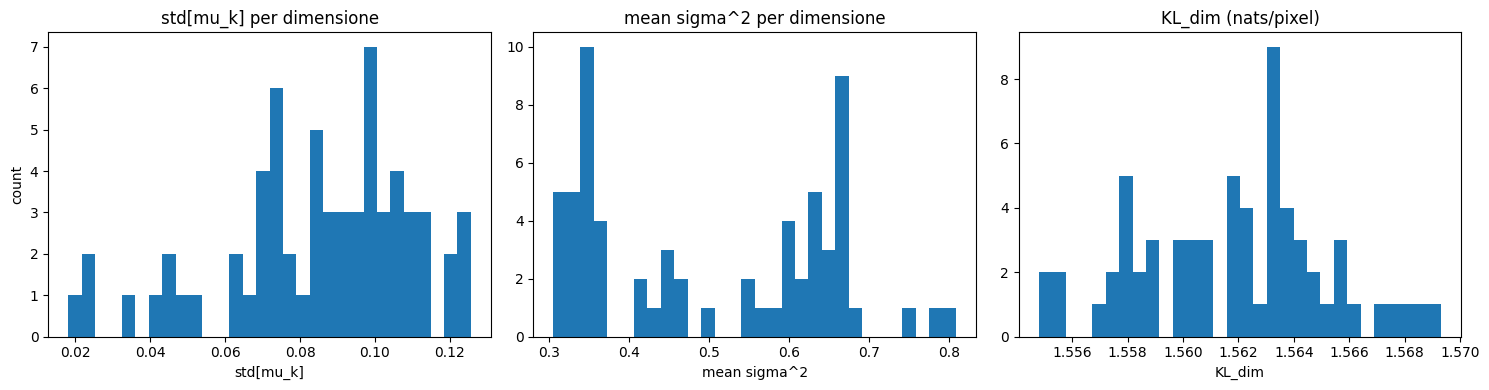

In [ ]:
#[Cell 5] Per-dimension diagnostics on MU/LOGVAR (TEST)


KL_THRESHOLD = 0.05   #nats per dimension per pixel (average over batch and H×W)
AU_EPS      = 1e-2    #threshold for "Active Units" (variance of mu_mean over dataset)
PLOT        = True

model.eval()

#latent collection on TEST
mus, logvars = [], []
with torch.inference_mode():
    for x, y in tqdm(test_loader, desc="Latent collection (test)", leave=False):
        x = x.to(device, non_blocking=True)
        mu, logvar = model.encoder(x)           #expected: (B, D, H, W)
        mus.append(mu.detach().cpu().numpy())
        logvars.append(logvar.detach().cpu().numpy())

MU      = np.concatenate(mus, axis=0)          #(N, D, H, W)
LOGVAR  = np.concatenate(logvars, axis=0)      #(N, D, H, W)
SIG2    = np.exp(LOGVAR)
N, D, H, W = MU.shape

#per-dimension metrics
#KL per pixel: 0.5 * (mu^2 + sigma^2 - logvar - 1)
KL_pp   = 0.5 * (MU**2 + SIG2 - LOGVAR - 1.0)  #(N, D, H, W)
KL_dim  = KL_pp.mean(axis=(0, 2, 3))           #(D,) average over batch and spatial dims
KL_tot  = KL_pp.sum(axis=(1, 2, 3)).mean()     #average total KL per sample

#Active Units (Chen et al., 2018): variance across dataset of the spatial mean of mu
MU_mean_per_sample = MU.mean(axis=(2, 3))      #(N, D)
AU = MU_mean_per_sample.var(axis=0)            #(D,)
MU_std = MU_mean_per_sample.std(axis=0)        #(D,)
SIG2_mean = SIG2.mean(axis=(0, 2, 3))          #(D,)

#classifications
inactive_kl   = KL_dim < KL_THRESHOLD
active_by_AU  = AU > AU_EPS
#"historical" heuristics
inactive_prior = (MU_std < 0.10) & (np.abs(SIG2_mean - 1.0) < 0.15)
active_det     = (MU_std > 0.30) & (SIG2_mean < 0.20)
active_mid     = (~inactive_prior) & (~active_det)

#report
print(f"\nTotal dimensions (D): {D}   | H×W: {H}×{W}   | N test: {N}")
print(f"Average total KL per sample (expected ~ log): {KL_tot:.2f} nats\n")

print(f"Inactive by KL (< {KL_THRESHOLD:.3f} nats/pixel): {inactive_kl.sum():2d}")
print(f"Active by AU  (> {AU_EPS:g})                  : {active_by_AU.sum():2d}")
print(f"[heuristics] Inactive ~ prior                 : {inactive_prior.sum():2d}")
print(f"[heuristics] Active (deterministic)           : {active_det.sum():2d}")
print(f"[heuristics] Active (intermediate)            : {active_mid.sum():2d}")

#Top-K dimensions by KL contribution
topk = min(10, D)
idx_top = np.argsort(-KL_dim)[:topk]
share = KL_dim / KL_dim.sum()
print("\nTop-K by KL_dim (mean nats/pixel) and share of total KL_dim:")
for i, d in enumerate(idx_top, 1):
    print(f"  #{i:02d} dim {d:02d}: KL_dim={KL_dim[d]:.4f}  | share={share[d]*100:5.2f}%  | AU={AU[d]:.3e}")

#plots
if PLOT:
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1); plt.hist(MU_std, bins=30);   plt.title("std[mu_k] per dimension");       plt.xlabel("std[mu_k]");      plt.ylabel("count")
    plt.subplot(1,3,2); plt.hist(SIG2_mean, bins=30);plt.title("mean sigma^2 per dimension");   plt.xlabel("mean sigma^2")
    plt.subplot(1,3,3); plt.hist(KL_dim, bins=30);   plt.title("KL_dim (nats/pixel)");          plt.xlabel("KL_dim")
    plt.tight_layout(); plt.show()


### [Cell 6] VAE Training Diagnostics

This section analyzes the **training history** of the VAE on CIFAR-10, focusing on key metrics to check convergence and model performance. The latent space has size $4 \times 4 \times 64$.  

---

### Metrics Tracked
* **Total Loss:** combines reconstruction error (MAE) and KL penalty.  
* **Reconstruction (MAE):** measures fidelity of decoded images.  
* **KL Divergence:**  
  Aggregated over $H \times W$ and batches → $\mathrm{KL}_{true}$.  
  With **capacity scheduling**, KL is pushed toward a target $C(t)$ to avoid collapse.  
* **β schedule:** here constant at $\beta = 0.3$, plotted to confirm stability.  
* **Optional:** eval@β curves or free-bits cap (disabled in this run).  

---

### Visualization
Plots (2×3 grid) compare train/test curves for loss, MAE, KL, and β. These confirm if the model follows $C(t)$ and whether overfitting appears.  


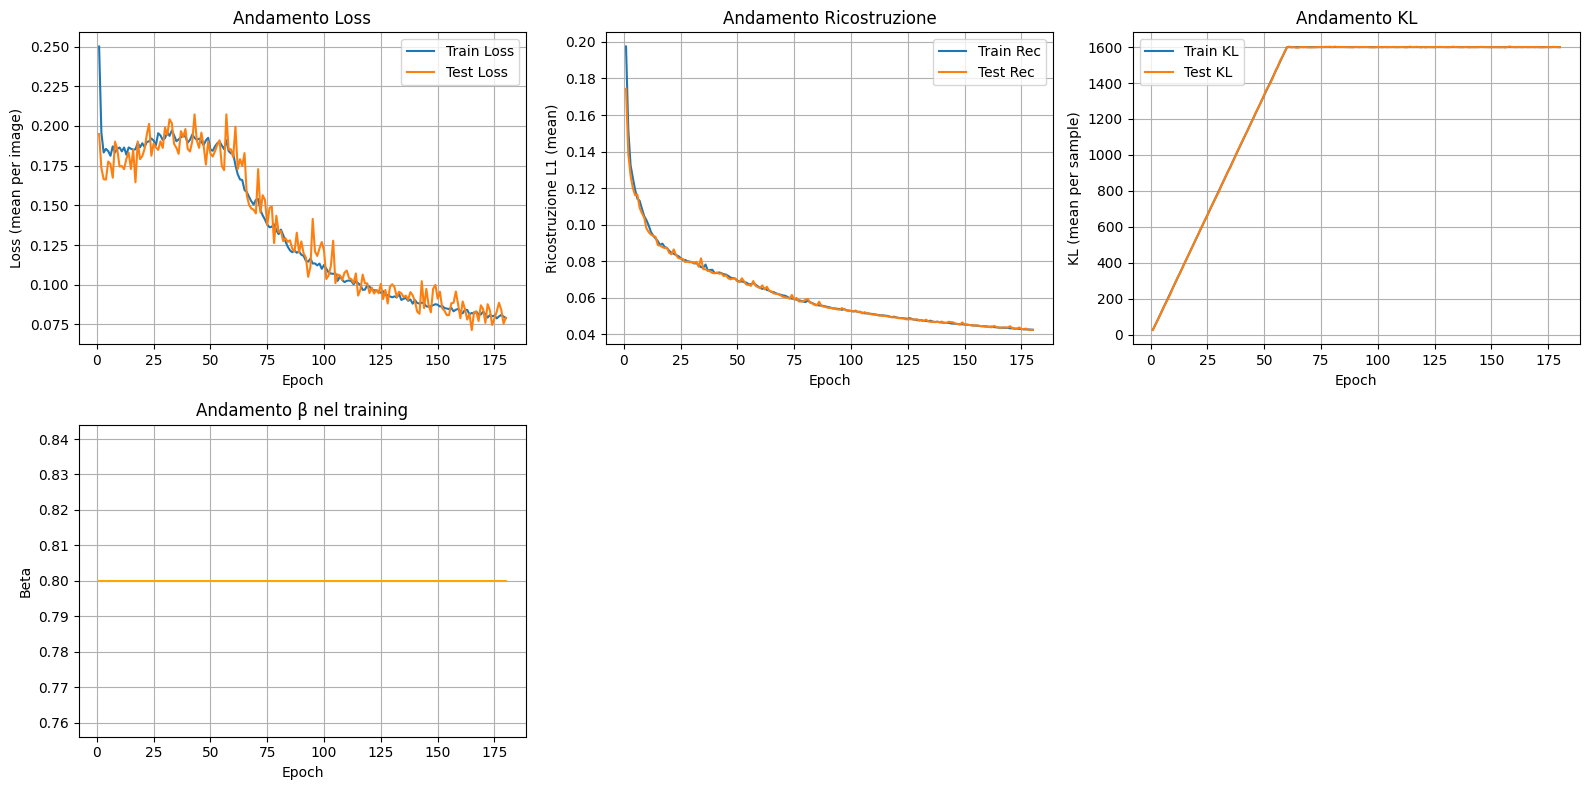

Metrica      | Minimo     | Epoch  | Beta  
---------------------------------------------
train_total  | 0.0788     | 176    | 0.800 
train_rec    | 0.0425     | 180    | 0.800 
train_kl     | 28.3711    | 1      | 0.800 
test_total   | 0.0715     | 165    | 0.800 
test_rec     | 0.0424     | 179    | 0.800 
test_kl      | 25.3315    | 1      | 0.800 


In [ ]:
# [Cell 6] Training trend (consistent with mean loss/kl + other plots)

hist_path = RESULTS_PATH / "history_vae_cifar10.npy"
if not hist_path.exists():
    print(f"❌ History not found: {hist_path}")
else:
    hist = np.load(hist_path, allow_pickle=True).item()
    epochs = hist["epoch"]

    plt.figure(figsize=(16, 8))

    # --- Loss (mean per image) ---
    plt.subplot(2, 3, 1)
    plt.plot(epochs, hist["train_total"], label="Train Loss")
    plt.plot(epochs, hist["test_total"], label="Test Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss (mean per image)")
    plt.title("Loss trend")
    plt.legend(); plt.grid(True)

    # --- Reconstruction (mean per image) ---
    plt.subplot(2, 3, 2)
    plt.plot(epochs, hist["train_rec"], label="Train Rec")
    plt.plot(epochs, hist["test_rec"], label="Test Rec")
    plt.xlabel("Epoch"); plt.ylabel("Reconstruction L1 (mean)")
    plt.title("Reconstruction trend")
    plt.legend(); plt.grid(True)

    # --- KL (mean per sample) ---
    plt.subplot(2, 3, 3)
    plt.plot(epochs, hist["train_kl"], label="Train KL")
    plt.plot(epochs, hist["test_kl"], label="Test KL")
    plt.xlabel("Epoch"); plt.ylabel("KL (mean per sample)")
    plt.title("KL trend")
    plt.legend(); plt.grid(True)

    # --- Beta Schedule ---
    plt.subplot(2, 3, 4)
    plt.plot(epochs, hist["beta"], color="orange")
    plt.xlabel("Epoch"); plt.ylabel("Beta")
    plt.title("β trend during training")
    plt.grid(True)

    # --- Eval@β ---
    if "eval_beta" in hist:
        plt.subplot(2, 3, 5)
        plt.plot(epochs, hist["eval_beta"], label="eval@β")
        plt.xlabel("Epoch"); plt.ylabel("Loss eval@β")
        plt.title("eval@β trend")
        plt.legend(); plt.grid(True)

    # --- Cap Free Bits ---
    if "cap" in hist:
        plt.subplot(2, 3, 6)
        plt.plot(epochs, hist["cap"], color="purple")
        plt.xlabel("Epoch"); plt.ylabel("Free-bits cap")
        plt.title("Free Bits cap evolution")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print table of minimum metrics
    metrics = ["train_total", "train_rec", "train_kl", "test_total", "test_rec", "test_kl"]
    print(f"{'Metric':<12} | {'Minimum':<10} | {'Epoch':<6} | {'Beta':<6}")
    print("-"*45)
    for m in metrics:
        values = np.array(hist[m])
        min_idx = np.argmin(values)
        min_val = values[min_idx]
        epoch = hist["epoch"][min_idx]
        beta  = hist["beta"][min_idx]
        print(f"{m:<12} | {min_val:<10.4f} | {epoch:<6} | {beta:<6.3f}")


### [Cell 7] Example reconstructions

This cell provides a **quick qualitative check** of the VAE’s ability to reconstruct images.  
It loads the **best checkpoint** (`vae_cifar10.pth`), switches the model to `eval()` mode, and takes a small batch from the test set.  

The batch is passed through the encoder–decoder:  
$$
x \;\;\xrightarrow{\text{VAE}}\;\; \hat{x}, \;\mu, \;\log\sigma^2
$$  
Here only the reconstruction $\hat{x}$ is kept.  

Eight original images and their reconstructions are displayed in a 2×8 grid (top row = originals, bottom row = reconstructions).  
The results show whether the **reconstruction loss (MAE)** has been optimized: reconstructions should be clean, though some blur or color shifts are expected since the decoder uses a sigmoid output and training balances fidelity with latent compression via capacity scheduling.  

This check confirms that the trained VAE on CIFAR-10 (latent map $4\times4\times64$) produces reasonable reconstructions, ensuring a usable latent space for later quantization and autoregressive modeling.  


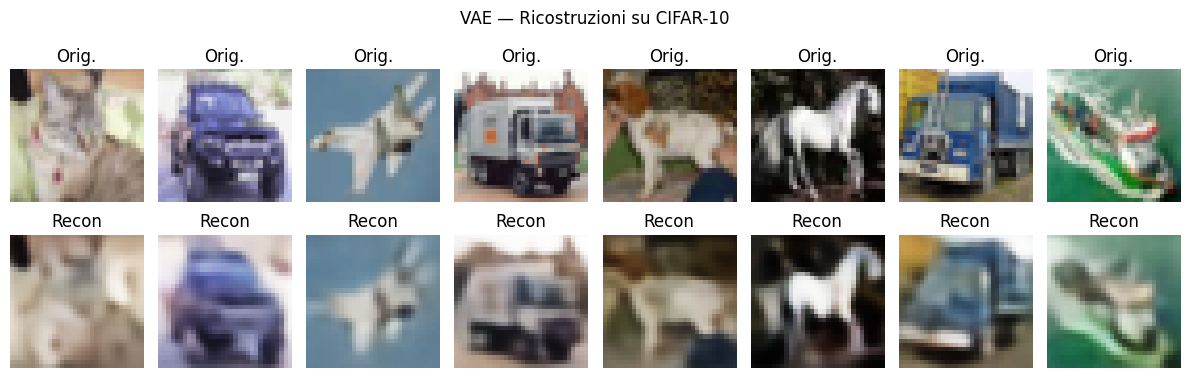

In [ ]:
#[Cell 7] Example reconstructions

#Load the best checkpoint (if not already in RAM)
if MODEL_SAVE_PATH.exists():
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
model.eval()

#Take a test batch
sample_images, _ = next(iter(test_loader))
sample_images = sample_images.to(device)

with torch.no_grad():
    recon, *_ = model(sample_images)  #simplified unpacking, compatible

imgs = sample_images[8:16].cpu().numpy()
recs = recon[8:16].cpu().numpy()

plt.figure(figsize=(12, 4))
for i in range(8):
    #originals
    ax = plt.subplot(2, 8, i + 1)
    plt.imshow(np.transpose(imgs[i], (1, 2, 0)))
    ax.set_title("Orig.")
    ax.axis('off')

    #reconstructed
    ax = plt.subplot(2, 8, 8 + i + 1)
    plt.imshow(np.transpose(recs[i], (1, 2, 0)))
    ax.set_title("Recon")
    ax.axis('off')

plt.suptitle("VAE — Reconstructions on CIFAR-10")
plt.tight_layout()
plt.show()


### [Cell 8] Latent Vector Extraction (μ)

This cell collects the **continuous latent means** ($\mu$) from the VAE encoder for the whole CIFAR-10 training set. These vectors will be the basis for geodesic quantization in the next stage.  

---

### How it works
* The VAE is set to `eval()` with gradients off.  
* Each batch from the `train_loader` is encoded into $(\mu, \log\sigma^2)$. Only $\mu$ is kept.  
* Shape from encoder: `(B, D, H, W)` with $D=64$, $H=W=4$. It is permuted to `(B, H, W, D)` and converted to NumPy.  
* All batches are concatenated → final array of shape:  
  $$
  (N, H, W, D) = (50000, 4, 4, 64)
  $$  
* Data stored as `float32` for efficiency.  

---

### Why it matters
Each image is compressed into **16 tokens** ($4 \times 4$), each a 64-dim vector.  
This preserves spatial structure and prepares for:  
* **Week 2:** building a k-NN graph + K-Medoids clustering with geodesic distance.  
* A **post-hoc quantization** approach: train a continuous VAE first, then discretize, ensuring rich representations before codebook construction.  


In [ ]:
#[Cell 8] Latent Vector Extraction (μ)
latent_list = []
model.eval()
with torch.no_grad():
    for data, _ in tqdm(train_loader, desc="Latent extraction (mu)"):
        data = data.to(device, non_blocking=True)
        mu, _ = model.encoder(data)  # mu: (B, D, H, W)
        mu_hw_last = mu.permute(0, 2, 3, 1).contiguous()  # -> (B, H, W, D)
        latent_list.append(mu_hw_last.cpu().numpy())

latent_vectors = np.concatenate(latent_list, axis=0).astype('float32')  # (N, H, W, D)

print(f"[OK] Latents extracted: {latent_vectors.shape}")


Estrazione latenti (mu): 100%|██████████| 196/196 [00:25<00:00,  7.64it/s]

[OK] Latenti estratti: (50000, 4, 4, 64)


### [Cell 9] Computation and saving (mu_train, sigma_train) + latent standardization

In [ ]:
#[Cell 9] Computation and saving (mu_train, sigma_train) + latent standardization

#Prerequisite: latent_vectors (N,H,W,D) from Cell 9
assert 'latent_vectors' in globals(), "latent_vectors not found: run Cell 9 first"
assert latent_vectors.ndim == 4, f"Unexpected shape: {latent_vectors.shape} (expected N,H,W,D)"

N, H, W, D = latent_vectors.shape

#Per-channel statistics
mu_train    = latent_vectors.mean(axis=(0, 1, 2)).astype('float32')  #(D,)
sigma_train = latent_vectors.std (axis=(0, 1, 2)).astype('float32')  #(D,)

#Paths
RESULTS_PATH = Path("results")
GEODESIC_QUANT_DIR = RESULTS_PATH / "geodesic_quant"
GEODESIC_QUANT_DIR.mkdir(parents=True, exist_ok=True)

date_str = datetime.now().strftime("%d_%m_%Y")
stable_npz = GEODESIC_QUANT_DIR / "geoq_standardization_stats.npz"
dated_npz  = GEODESIC_QUANT_DIR / f"geoq_standardization_stats_{date_str}.npz"
meta_json  = GEODESIC_QUANT_DIR / "geoq_standardization_stats.json"

#Save stats
np.savez(dated_npz,  mu=mu_train, sigma=sigma_train, axes="mean/std over (N,H,W), per-channel")
np.savez(stable_npz, mu=mu_train, sigma=sigma_train, axes="mean/std over (N,H,W), per-channel")

#Save metadata
meta = {
    "D": int(D),
    "axes": "per-channel over (N,H,W)",
    "mu_mean": float(mu_train.mean()),
    "mu_min":  float(mu_train.min()),
    "mu_max":  float(mu_train.max()),
    "sigma_mean": float(sigma_train.mean()),
    "sigma_min":  float(sigma_train.min()),
    "sigma_max":  float(sigma_train.max()),
    "stable_npz": str(stable_npz.resolve()),
    "dated_npz":  str(dated_npz.resolve()),
}
with open(meta_json, "w") as f:
    json.dump(meta, f, indent=2)

#Standardize using the just-computed stats
latent_vectors = (latent_vectors - mu_train[None, None, None, :]) / (sigma_train[None, None, None, :] + 1e-6)

#Save standardized latents
out_path = RESULTS_PATH / f"training_latent_mus_{date_str}.npy"
np.save(str(out_path), latent_vectors)

print("=== Standardization completed ===")
print(f"mu_train   : {mu_train.shape} mean={mu_train.mean():.4f} min={mu_train.min():.4f} max={mu_train.max():.4f}")
print(f"sigma_train: {sigma_train.shape} mean={sigma_train.mean():.4f} min={sigma_train.min():.4f} max={sigma_train.max():.4f}")
print("Saved files:")
print(" -", stable_npz.resolve())
print(" -", dated_npz.resolve())
print(" -", meta_json.resolve())
print(" -", out_path.resolve())


=== Standardization completata ===
mu_train   : (64,) mean=-0.0019 min=-0.1547 max=0.1263
sigma_train: (64,) mean=0.3735 min=0.2017 max=1.4966
File salvati:
 - C:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\geodesic_quant\geoq_standardization_stats.npz
 - C:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\geodesic_quant\geoq_standardization_stats_27_08_2025.npz
 - C:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\geodesic_quant\geoq_standardization_stats.json
 - C:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\training_latent_mus_27_08_2025.npy


### References

- **Krizhevsky, A.** (2009). *Learning Multiple Layers of Features from Tiny Images*. Technical Report, University of Toronto.  
  [Original source of the CIFAR-10 dataset used for VAE training.]

- **Kingma, D. P., & Welling, M.** (2014). *Auto-Encoding Variational Bayes*. arXiv:1312.6114.  
  [Foundational paper introducing Variational Autoencoders (VAE).]

- **He, K., Zhang, X., Ren, S., & Sun, J.** (2016). *Deep Residual Learning for Image Recognition*. In CVPR.  
  [Origin of Residual Blocks (ResNet), applied in the encoder/decoder of the VAE.]

- **Wu, Y., He, K., & Xie, S.** (2020). *Group Normalization*. In ECCV.  
  [Reference for GroupNorm, adopted for stable training with small batches.]

- **Hendrycks, D., & Gimpel, K.** (2016). *Gaussian Error Linear Units (GELUs)*. arXiv:1606.08415.  
  [Source of the SiLU/Swish activation function used in the architecture.]

- **Burgess, C. P., Higgins, I., Pal, A., Matthey, L., Watters, N., Desjardins, G., & Lerchner, A.** (2018). *Understanding Disentangling in β-VAE*. arXiv:1804.03599.  
  [Introduces capacity scheduling for KL regularization.]

- **Chen, R. T. Q., Li, X., Grosse, R. B., & Duvenaud, D. K.** (2018). *Isolating Sources of Disentanglement in Variational Autoencoders*. In NeurIPS.  
  [Origin of the “Active Units” diagnostic for posterior collapse.]
